In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

In [ ]:
df = pd.read_csv("Mall_Customers.csv")

In [ ]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
df.shape

(200, 5)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [ ]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [ ]:
df = df.drop(columns=['CustomerID'])



In [ ]:
df_num = df.select_dtypes(include=['int64', 'float64'])
df_cat = df.select_dtypes(include=['object'])

<Figure size 2400x1300 with 0 Axes>

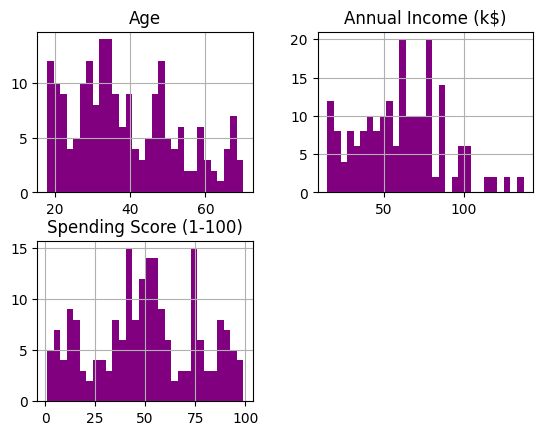

In [ ]:
plt.figure(figsize=(24, 13))
df.hist( bins=30 , color = "purple")
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.show()

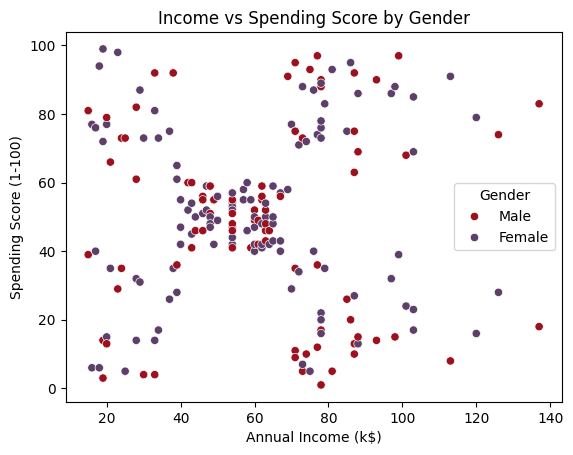

In [ ]:
palette1 = {'Male': '#9B111E', 'Female': '#5D3F6A'}
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender' , palette=palette1 )
plt.title("Income vs Spending Score by Gender")
plt.show()

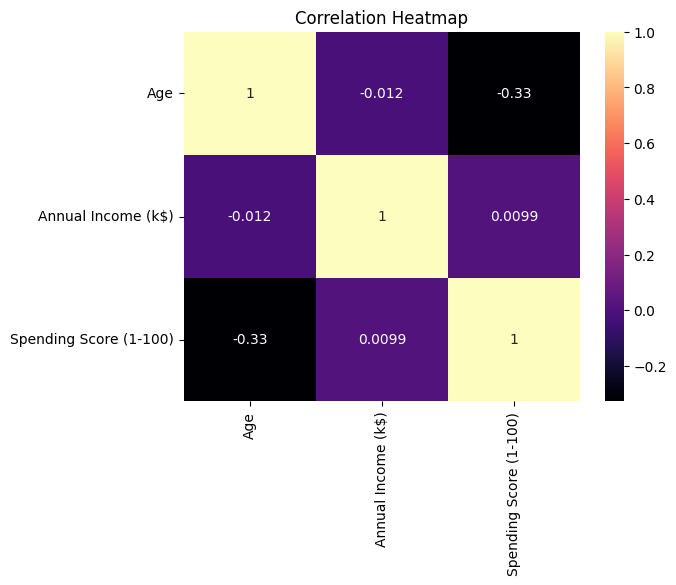

In [ ]:
sns.heatmap(df_num.corr(), annot=True, cmap='magma')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
scaler = StandardScaler()
df[df_num.columns] = scaler.fit_transform(df[df_num.columns])
df = pd.get_dummies(df, drop_first=True)

df.head()


,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,-1.424569,-1.738999,-0.434801,True
1,-1.281035,-1.738999,1.195704,True
2,-1.352802,-1.700830,-1.715913,False
3,-1.137502,-1.700830,1.040418,False
4,-0.563369,-1.662660,-0.395980,False


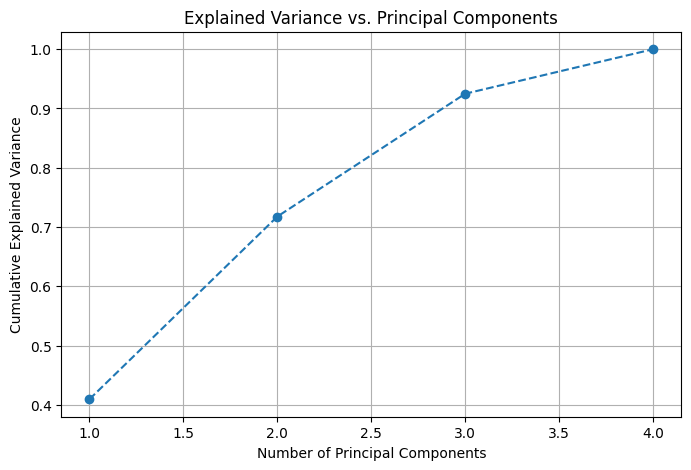

Number of components selected: 4


,PC1,PC2,PC3,PC4
0,0.600438,1.737179,-1.322247,-0.655372
1,1.649886,1.789124,-0.067789,-0.693393
2,-0.315381,1.692772,-2.179818,0.379872
3,1.477989,1.781317,-0.078518,0.314797
4,0.060545,1.678691,-0.688083,0.370265


In [ ]:
#Center the data
df_centered = df - df.mean()

# Compute the covariance matrix
cov_matrix = np.cov(df_centered.T)

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort eigenvalues and eigenvectors by descending eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[:, sorted_indices]

# Select top N components
explained_variance_ratio = eigenvalues_sorted / np.sum(eigenvalues_sorted)
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio and cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Principal Components')
plt.grid(True)
plt.show()

# Choose N components ( 2 components for visualization, if cumulative variance >= 0.95)
N = np.argmax(cumulative_variance >= 0.95) + 1  # Find the minimum N for 95% variance
print(f"Number of components selected: {N}")

# Project the data onto the top N eigenvectors
df_pca = np.dot(df_centered, eigenvectors_sorted[:, :N])

# Output transformed data
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(N)])
df_pca.head()


<ipython-input-33-7d66cb567854>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_pca['PC1'], df_pca['PC2'], cmap='viridis')


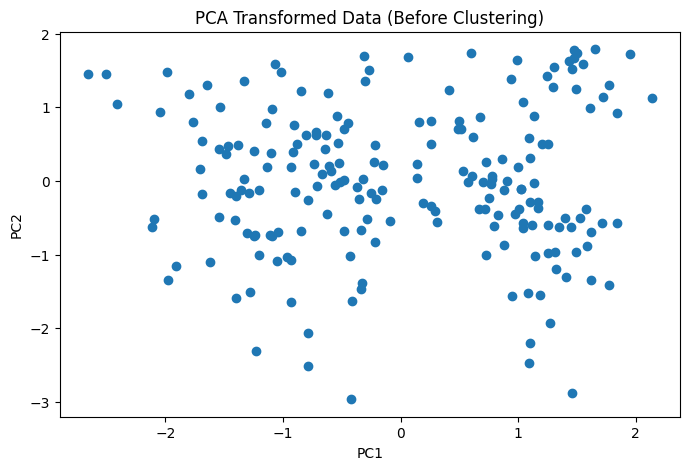

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(df_pca['PC1'], df_pca['PC2'], cmap='viridis')
plt.title('PCA Transformed Data (Before Clustering)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [ ]:
# Initialize centroids randomly
def initialize_centroids(X, k):
    # Randomly choose k points from the data as initial centroids
    random_indices = np.random.choice(X.shape[0], size=k, replace=False)
    centroids = X[random_indices]
    return centroids

# Assign data points to the nearest centroid
def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    cluster_assignments = np.argmin(distances, axis=1)
    return cluster_assignments

# Update centroids based on assigned clusters
def update_centroids(X, cluster_assignments, k):
    new_centroids = np.array([X[cluster_assignments == i].mean(axis=0) for i in range(k)])
    return new_centroids

# Implement K-Means algorithm
def kmeans(X, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(X, k)
    for i in range(max_iters):
        cluster_assignments = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, cluster_assignments, k)

        # Check for convergence (if centroids don't change much)
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    return cluster_assignments, centroids



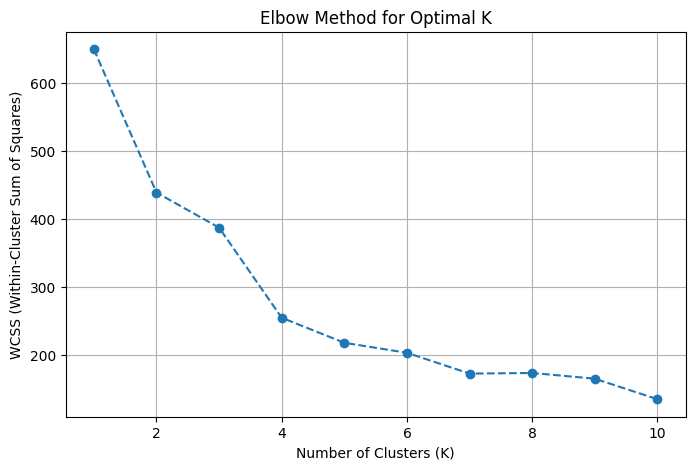

In [ ]:
# Step 1: Using Elbow Method to determine the optimal K
wcss = []  # List to store WCSS values

# Try K from 1 to 10
for k in range(1, 11):
    # Apply K-Means (handmade)
    cluster_assignments, centroids = kmeans(df_pca.values, k)

    # Calculate WCSS (within-cluster sum of squares)
    wcss_value = 0
    for i in range(k):
        cluster_points = df_pca.values[cluster_assignments == i]
        cluster_center = centroids[i]
        wcss_value += np.sum((cluster_points - cluster_center) ** 2)  # Sum of squared distances
    wcss.append(wcss_value)

# Step 2: Plot WCSS to find the "Elbow"
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()


In [ ]:
# Apply K-Means to the PCA-transformed data (df_pca)
k = 4 # Choosen from the graph
cluster_assignments, centroids = kmeans(df_pca.values, k)

# Add cluster assignments to the df_pca for visualization or analysis
df_pca['Cluster'] = cluster_assignments


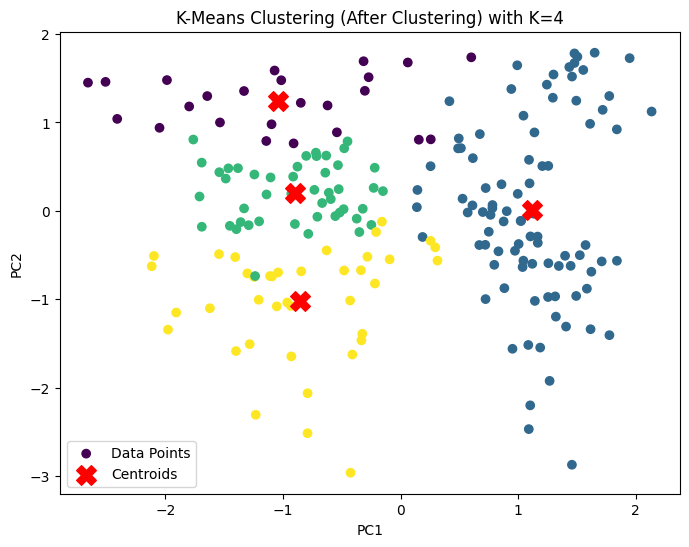

In [ ]:
# Visualize K-Means clustering result after applying the algorithm
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')  # Plot centroids
plt.title(f'K-Means Clustering (After Clustering) with K={k}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


In [ ]:
# Analyze cluster characteristics by calculating mean values of the features for each cluster
# For PCA-transformed features
cluster_means_pca = df_pca.groupby('Cluster').mean()
print("Cluster Centers (Centroids):")
print(centroids)
print("Cluster Characteristics (PCA-transformed features):")
print(cluster_means_pca)

# For the original features
df['Cluster'] = cluster_assignments
cluster_means_original = df.groupby('Cluster').mean()
print("\nCluster Characteristics (Original features):")
print(cluster_means_original)


Cluster Centers (Centroids):
[[-1.04178315  1.23734692 -0.56171609  0.05369707]
 [ 1.11750323  0.00620946  0.0670465  -0.03518135]
 [-0.8975943   0.20188213  0.81361462  0.04220081]
 [-0.85604008 -1.01906763 -0.78956118 -0.002714  ]]
Cluster Characteristics (PCA-transformed features):
              PC1       PC2       PC3       PC4
Cluster                                        
0       -1.041783  1.237347 -0.561716  0.053697
1        1.117503  0.006209  0.067046 -0.035181
2       -0.897594  0.201882  0.813615  0.042201
3       -0.856040 -1.019068 -0.789561 -0.002714

Cluster Characteristics (Original features):
              Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
Cluster                                                                   
0        0.306803           -1.282556               -1.091533     0.375000
1       -0.742785            0.042665                0.837252     0.433333
2        1.204841           -0.235773               -0.052368     0.425532
3    